# Implementation of OU Model Jurek

This notebook demonstrates the usage of the `ou_model_jurek` module.

This module contains implementation of the following paper 

- [Dynamic portfolio selection in arbitrage. (2007)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=882536) by Jurek, J.W. and Yang, H.


## Introduction



In the paper corresponding to this module, the authors derive the optimal dynamic strategy for arbitrageurs with a finite horizon and
non-myopic preferences facing a mean-reverting arbitrage opportunity (e.g. an equity pairs
trade).

The law of one price asserts that - in a frictionless market - securities with identical payoffs
must trade at identical prices. If this were not the case, arbitrageurs could generate a riskless
profit by supplying (demanding) the expensive (cheap) asset until the mispricing was eliminated.
Of course, real world markets are not frictionless, and the prices of securities with identical payoffs
may significantly diverge for extended periods of time. Arbitrageurs can earn potentially attractive
profits by taking offsetting positions in these relatively mispriced securities, but a worsening of the
mispricing can result in sizable capital losses.

Unlike textbook arbitrages, which generate riskless profits and require no capital commitments,
exploiting real-world mispricings requires the assumption of some combination of horizon and divergence risk.
These two risks represent the uncertainty about whether the mispricing will converge before the positions
must be closed (or profits reported) and the possibility of a worsening in the mispricing prior to its elimination.

While a complete treatment of optimal arbitrage and price formation requires a general equilibrium framework,
this paper takes on the more modest goal of examining the arbitrageur's strategy in
partial equilibrium.

## Modelling


To capture the presence of horizon and divergence risk, the authors model the dynamics of the mispricing
using a mean-reverting stochastic process. Under this process, although the mispricing is guaranteed
to be eliminated at some future date, the timing of convergence, as well as the maximum magnitude
of the mispricing prior to convergence, are uncertain. With this assumption, the authors are able to derive
the arbitrageur's optimal dynamic portfolio policy for a set of general, non-myopic preference
specifications, including CRRA utility defined over wealth at a finite horizon and Epstein-Zin
utility defined over intermediate cash flows (e.g. fees). 

The central assumption of our model is that the arbitrage opportunity is described by an
Ornstein-Uhlenbeck process (henceforth OU). The OU process captures the two key features of a
real-world mispricing: the convergence times are uncertain and the mispricing can diverge arbitrarily far
from its mean prior to convergence.

The optimal trading strategies derived are self-financing and can be interpreted as the optimal
trading rules for a fund which is not subject to withdrawals but also cannot raise additional assets
(i.e. a closed-end fund). The dynamics of the optimal allocation to the arbitrage opportunity are
driven by two factors: the necessity of maintaining wealth (equity) above zero and the proximity
of the arbitrageur's terminal evaluation date, which affects his appetite for risk.


### Investor Preferences

The authors considered two alternative preferences structures for the arbitrageur in our continuous-time
model. In the first, the authors assumed that the agent has constant relative risk aversion and maximizes
the discounted utility of terminal wealth. The arbitrageur's value function at time $t$ - denoted by
$V_t$ - takes the form:

$$
    V_{t}=\sup E_{t}\left[e^{-\beta(T-t)} \frac{W_{T}^{1-\gamma}}{1-\gamma}\right]
$$


The second preference structure they considered is the recursive utility of Epstein and Zin (1989, 1991),
which allows the elasticity of intertemporal substitution and the coefficient of relative risk aversion
to vary independently. Under this preference specification, the value function of the arbitrageur is
given by:

$$
    V_{t}=\sup E_{t}\left[\int_{t}^{T} f\left(C_{s}, J_{s}\right) d s\right]
$$


where $f\left(C_{s}, J_{s}\right)$ is the normalized aggregator for the continuous-time Epstein-Zin utility function:

$$
    f\left(C_{t}, J_{t}\right)=\beta(1-\gamma) \cdot J_{t} \cdot\left[\log C_{t}-\frac{1}{1-\gamma} \log \left((1-\gamma) J_{t}\right)\right]
$$


Here the authors considered the special case of a unit elasticity of intertemporal substitution ($\psi = 1$).


Here $C_t$ denotes the instantaneous consumption (e.g. cash flow). $\beta$ is the rate of time preference, and
$\gamma$ is the coefficient of relative risk aversion.



---

## How to use this submodule

This submodule contains seven public methods, of which two methods are necessary to calculate the optimal weights.
The first method `fit` is for estimating the parameters of the model
using training data, and the second method `optimal_portfolio_weights` is for calculating the final optimal portfolio weights using evaluation data.

### Imports and Loading the dataset

We use the $GLD$ and $GDX$ tickers daily close prices as our dataset. To get good results for the estimated parameters, using  10 years of training data is recommended.


The training data comprises of data from years $2009$ to $2019$. The optimal weights are calculated on data from $2019$ to $2020$.

In [37]:
# Importing required modules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf

from arbitragelab.stochastic_control_approach.ou_model_jurek import OUModelJurek

# Downloading the data
data1 = yf.download("BTC-USD ETH-USD", start="2017-12-01", end="2022-01-01")
data2 = yf.download("BTC-USD ETH-USD", start="2023-01-01", end="2024-01-01")

# Using the Adj Close prices for our dataset
data_train_dataframe = data1["Adj Close"][["BTC-USD", "ETH-USD"]]
data_test_dataframe = data2["Adj Close"][["BTC-USD", "ETH-USD"]]

print("Training Data")
print(data_train_dataframe.head())

print("Testing Data")
print(data_test_dataframe.head())

[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed

Training Data
Ticker           BTC-USD     ETH-USD
Date                                
2017-12-01  10975.599609  466.540009
2017-12-02  11074.599609  463.449005
2017-12-03  11323.200195  465.852997
2017-12-04  11657.200195  470.204010
2017-12-05  11916.700195  463.281006
Testing Data
Ticker           BTC-USD      ETH-USD
Date                                 
2023-01-01  16625.080078  1200.964844
2023-01-02  16688.470703  1214.656616
2023-01-03  16679.857422  1214.778809
2023-01-04  16863.238281  1256.526611
2023-01-05  16836.736328  1250.438599


### Model fitting


We input the training data to the `fit` method which calculates the spread
and the closed form estimators of the parameters of the model.

We can also specify the time period between steps(delta_t) in the data
and whether we want to run the ADF statistic test to evaluate the spread.

#### Spread Construction

To construct the spread for the portfolio, firstly the authors calculated the total return index for each asset $i$ in the spread.

$$
    P_{i, t}=\left(\frac{1}{P_{i, 1}}\right) \cdot\left(P_{i, 1} \cdot \prod_{j=1}^{t-1}\left(1+R_{i, j+1}\right)\right)
$$

The price spread is then constructed by taking a linear combination of the total return indices.
These weights are estimated by using a co-integrating regression technique such as Engle Granger.

In [38]:
# Creating an object of the Jurek class
sc = OUModelJurek()

# Calling the fit method on the train dataset
sc.fit(data_train_dataframe, delta_t = 1/252)

/home/shinpachi/Lab/arbitragelab/arbitragelab/stochastic_control_approach/ou_model_jurek.py:93: UserWarning: Please make sure length of training data is greater than 10 years. This is the time period used to fit the model in the original paper.
  warnings.warn("Please make sure length of training data is greater than 10 years. "


To view the estimated model parameters from training data, we can use the `describe` function in the class object.

In [39]:
display(pd.DataFrame(sc.describe(), columns=['Values']))

,Values
Ticker of first stock,BTC-USD
Ticker of second stock,ETH-USD
Scaled Spread weights,"[0.633, -0.367]"
long-term mean,0.322693
rate of mean reversion,1.729919
standard deviation,0.705543
half-life,0.400682


### Getting the Optimal Portfolio Weights

In this step we input the evaluation data and specify the type of investor we are looking for.
We also need to specify the utility function parameter $\gamma$ and the risk free rate of return $r$.

If we choose the investor with intermediate consumption, we also need to specify the parameter $\beta$.

#### Optimal Portfolio Strategy

The portfolio consists of a riskless asset and the mean reverting spread. The authors denote
the prices of the two assets by $B_t$ and $S_t$, respectively. Their dynamics are given by,

$$
    \begin{aligned}
    d B_{t} &=r B_{t} d t \\
    d S_{t} &=\kappa\left(\bar{S}-S_{t}\right) d t+\sigma d Z
    \end{aligned}
$$


The evolution of wealth which determines the budget constraints is written as,

$$
    d W_{t}=N_{t} d S_{t}+M_{t} d B_{t}-C_{t} 1\left[C_{t}>0\right] d t
$$


where $N_t$ denotes the number of units of spread, $M_t$ denotes the number of riskless assets and,
$1[C_{t}>0]$ is an indicator variable for whether intermediate consumption is taking place.

For the terminal wealth problem, the optimal portfolio allocation is given by:

$$
    N(W, S, \tau)=\left\{\begin{array}{cc}
    \left(\frac{\kappa(\bar{S}-S)-r S}{\sigma^{2}}\right) W & \gamma=1 \\
    \left(\frac{\kappa(\bar{S}-S)-r S}{\gamma \sigma^{2}}+\frac{2 A(\tau) S+B(\tau)}{\gamma}\right) W & \gamma \neq 1
    \end{array}\right.
$$


The functions $A(\tau)$ and $B(\tau)$ depend on the time remaining to the horizon and the parameters of the underlying model.

For the intermediate consumption problem, the optimal portfolio allocation has the same form as the corresponding equation for terminal wealth problem.

Obviously, the functional form of the coefficient functions $A(\tau)$ and $B(\tau)$ are different.


$\color{#FF0000}{\textrm{ WARNING }}$ : For utility_type = 2 and low values of $\gamma (< 1)$, the model becomes unstable with respect to the value of $k$.



---

The output of the `optimal_portfolio_weights` method is the portfolio weights of the spread scaled w.r.t wealth. i.e, $\frac{N(t)}{W(t)}$

---

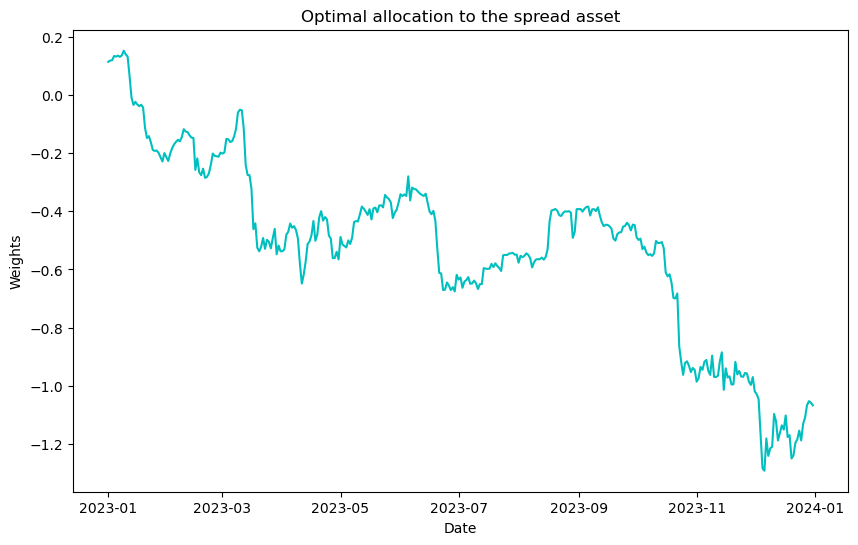

In [40]:
# In this example, we are considering the CRRA investor(utility_type = 1), with gamma = 2

# Plotting the portfolio weights of the spread asset
plt.figure(figsize=(10, 6))
scaled_weights = sc.optimal_portfolio_weights(data_test_dataframe, gamma=2, utility_type=1)
plt.plot(data_test_dataframe.index, scaled_weights, 'c-')
plt.title("Optimal allocation to the spread asset")
plt.ylabel("Weights")
plt.xlabel("Date")
plt.show()

To calculate the wealth process we make use of the following equations.

For CRRA investor with `utility_type = 1`,
$$
    \\
    d W_{t}=W_{t} \frac{N_{t}}{W_{t}} d S_{t} + r W_{t}(1 - \frac{N_{t}}{W_{t}} S_{t}) d t
    \\
$$

For investor with utility defined over intermediate consumption $ C_{t} =  \beta W_{t}$ with `utility_type = 2`,

$$
    d W_{t}=W_{t} \frac{N_{t}}{W_{t}} d S_{t} + r W_{t}(1 - \frac{N_{t}}{W_{t}} S_{t}) d t - \beta W_{t} d t
$$


where $d W_{t}$ can be written as $W_{t+1} - W_{t}$ and,

$d S_{t}$ can be written as $S_{t+1} - S_{t}$ .

In [41]:
def plot_wealth_process(obj, data, optimal_weights, utility_type):
    """
    Function for plotting the wealth process.
    """
    
    tau, S = obj.spread_calc(data)
    W = np.ones(len(tau))

    if utility_type == 1:
        for i in range(len(data) - 1):
            # Calculating the wealth process for CRRA investor. Follows equation (3) in Appendix A
            W[i + 1] = W[i] + W[i] * optimal_weights[i] * (S[i + 1] - S[i]) + obj.r * W[i] * (
                        1 - optimal_weights[i] * S[i]) * obj.delta_t

    elif utility_type == 2:
        for i in range(len(data) - 1):
            # Calculating the wealth process for investor with intermediate consumption
            # Follows equation (39) in Appendix A
            # Here we add an extra term which denotes consumption
            W[i + 1] = W[i] + W[i] * optimal_weights[i] * (S[i + 1] - S[i]) + obj.r * W[i] * (
                        1 - optimal_weights[i] * S[i]) * obj.delta_t - obj.beta * W[i] * obj.delta_t
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, W, 'c-')
    plt.title("Wealth process with initial wealth normalized to 1")
    plt.ylabel("Wealth")
    plt.xlabel("Date")
    plt.show()

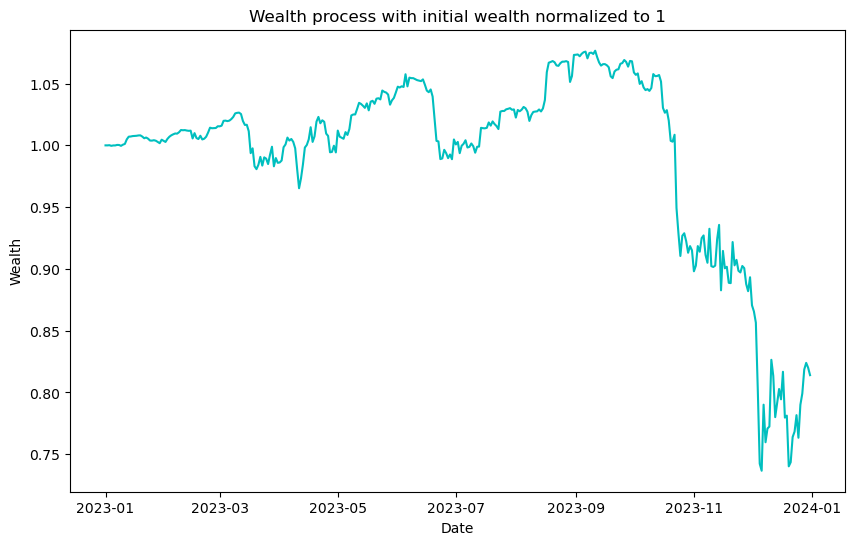

In [42]:
# Plotting the corresponding wealth process for the calculated weights above.
plot_wealth_process(sc, data_test_dataframe, scaled_weights, utility_type = 1)

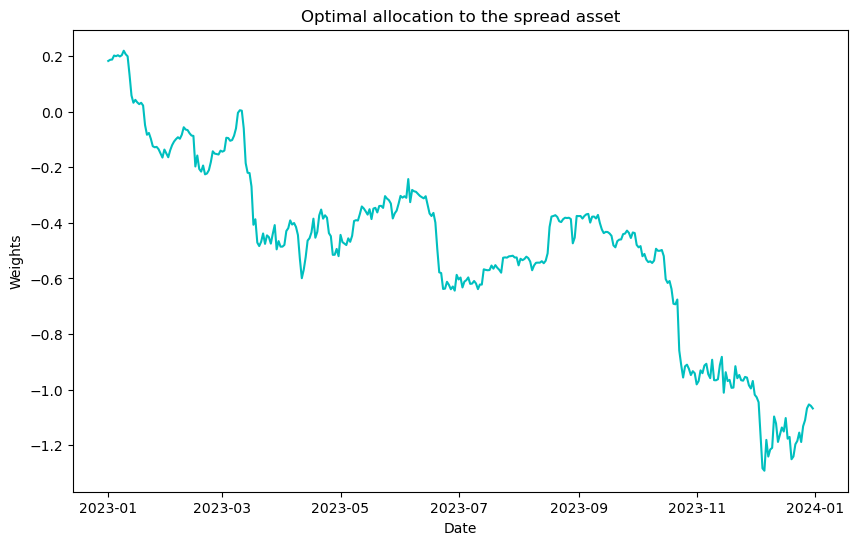

In [43]:
# In this example, we are considering the investor with utility defined over intermediate consumption(utility_type = 2), with gamma = 2

# Plotting the portfolio weights of the spread asset
plt.figure(figsize=(10, 6))
scaled_weights = sc.optimal_portfolio_weights(data_test_dataframe, gamma=2, utility_type=2)
plt.plot(data_test_dataframe.index, scaled_weights, 'c-')
plt.title("Optimal allocation to the spread asset")
plt.ylabel("Weights")
plt.xlabel("Date")
plt.show()

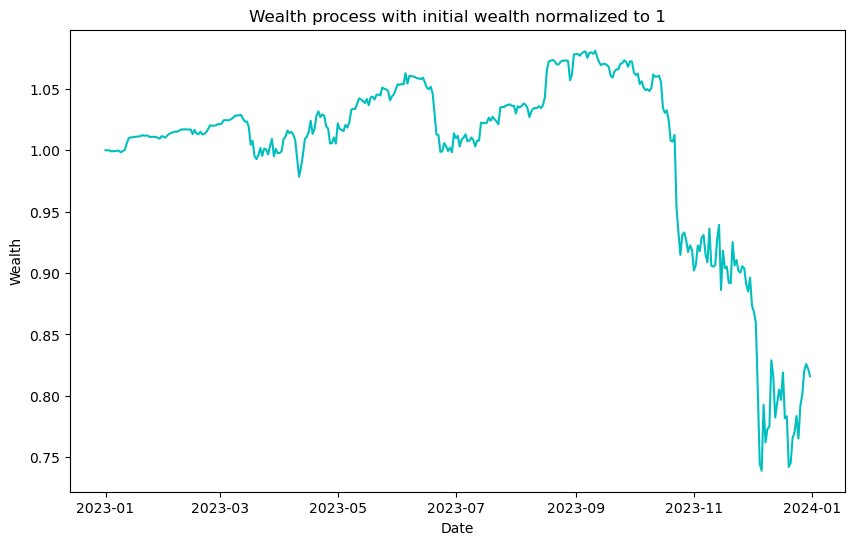

In [44]:
# Plotting the corresponding wealth process for the calculated weights above.
plot_wealth_process(sc, data_test_dataframe, scaled_weights, utility_type = 2)

### Stabilization Region

In this optional step, we can calculate the boundaries of the stabilization region for the spread calculated from the data.


In this section, the authors are interested in determining the direction in which an arbitrageur trades in response
to a shock to the value of the spread asset. If an arbitrageur increases his position in the spread asset
in response to an adverse shock, his trading is likely to have a stabilizing effect on the mispricing,
contributing to its elimination in equilibrium. Conversely, if the arbitrageur decreases his position
in response to the adverse shock, his trading will tend to exacerbate the mispricing.

Sometimes arbitrageurs do not arbitrage. For instance, if the mispricing is sufficiently wide, a divergence
in the mispricing can result in the decline of the total allocation, as the wealth effect dominates
the improvement in the investment opportunity set. To characterize the conditions under which arbitrageurs cease
to trade against the mispricing, the authors derived precise, analytical conditions for the time-varying envelope within which
arbitrageurs trade against the mispricing.

In the general case when $\bar{S} \neq 0$ the range of values of $S$
for which the arbitrageur's response to an adverse shock is stabilizing - i.e. the agent trades against
the spread, increasing his position as the spread widens - is determined by a time-varying envelope
determined by both $A(\tau)$ and $B(\tau)$. The boundary of the stabilization region is determined by the
following inequality:

$$
    \left| \phi(\tau) S+\frac{\kappa \bar{S}+\sigma^{2} B(\tau)}{\gamma \sigma^{2}}\right |<\sqrt{-\phi(\tau)}
$$

where,

$$
    \phi(\tau) = \left(\frac{2 A(\tau)}{\gamma}-\frac{\kappa+r}{\gamma \sigma^{2}}\right)
$$

As long as the spread is within the stabilization region, the improvement in investment opportunities
from a divergence of the spread away from its long-run mean outweighs the negative
wealth effect and the arbitrageur increases his position, $N$, in the mean-reverting asset. When
the spread is outside of the stabilization region, the wealth effect dominates, leading the agent to
curb his position despite an improvement in investment opportunities.


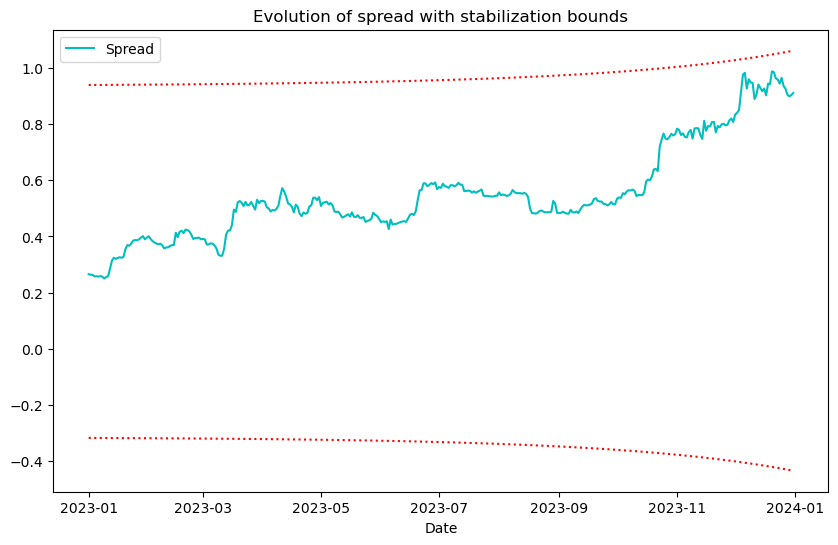

In [45]:
# In this example, we are considering the CRRA investor(utility_type = 1), with gamma = 2

S, min_bound, max_bound = sc.stabilization_region(data_test_dataframe, beta=0.01, gamma=2, utility_type=1)

# Plotting the stabilization bounds and the spread.
plt.figure(figsize=(10, 6))
plt.plot(data_test_dataframe.index, S , 'c-', label='Spread')
plt.plot(data_test_dataframe.index, min_bound, 'r:')
plt.plot(data_test_dataframe.index, max_bound, 'r:')
plt.title("Evolution of spread with stabilization bounds")
plt.xlabel("Date")
plt.legend()
plt.show()

### Optimal Portfolio Weights with Fund Flows


In this optional step, we calculate the optimal portfolio weights with the inclusion of fund flows for the CRRA investor.



#### Fund Flows

This section deals with the inclusion of fund flows. Delegated managers are not only exposed to the
financial fluctuations of asset prices but also to their client's desires to contribute or withdraw funds.
Paradoxically, clients are most likely to withdraw funds after performance has been poor
(i.e. spreads have been widening) and investment opportunities are the best.

In the presence of fund flows the evolution of wealth under management will depend not only
on performance, denoted by $\Pi_t$, but also on fund flows, $F_t$. Consequently:

$$
    \begin{aligned}
    d \Pi &=\tilde{N} d S+(W-\tilde{N} S) r d t \\
    d F &=f d \Pi+\sigma_{f} W d Z_{f} \\
    d W &=d \Pi+d F=(1+f) d \Pi+\sigma_{f} W d Z_{f}
    \end{aligned}
$$

where $\tilde{N}$ is the optimal policy rule chosen by a fund manager facing fund flows of the type described
above, and $E[d Z_{f} dZ] = 0$. The fund flow magnifies the effect of performance on wealth
under management, with each dollar in performance generating a fund flow of $f$ dollars.


The optimal portfolio allocation of an agent with constant relative risk aversion with utility
defined over terminal wealth, in the presence of fund flows is given by:

$$
    \tilde{N}(S, \tau)=\left(\frac{1}{1+f}\right) \cdot N(S, \tau)
$$

where $N(S, \tau)$ is the optimal policy function in the problem without fund flows
and $f$ denotes the proportionality coefficient.

The intuition behind this elegant solution is simple. The performance-chasing component of
fund flows increases the volatility of wealth by a factor of $(1 + f)$, causing a manager who anticipates
this flow to commensurately decrease the amount of risk taken on by the underlying strategy.


---

The output of the `optimal_portfolio_weights_fund_flows` method is the portfolio weights of the spread scaled w.r.t wealth.

---

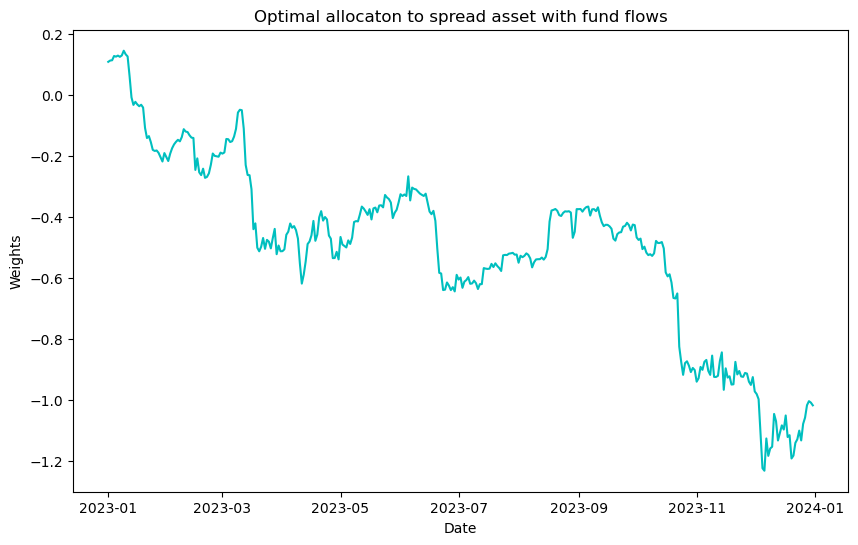

In [46]:
# In this example, we are considering the CRRA investor(utility_type = 2), with gamma = 2 and f = 0.05

# Plotting the portfolio weights of the spread asset with fund flows
plt.figure(figsize=(10, 6))
plt.plot(data_test_dataframe.index, sc.optimal_portfolio_weights_fund_flows(data_test_dataframe, f=0.05, gamma=2), 'c-')
plt.title("Optimal allocaton to spread asset with fund flows")
plt.ylabel("Weights")
plt.xlabel("Date")
plt.show()

### Plotting Results

In this optional step, we can use the `plot_results` method to plot the out of sample performance of the model on specified number of test windows. This method plots the stabilization bound, optimal portfolio weights and optimal portfolio weights with fund flows.

---

This method requires the input dataset to be length greater than 10 years.

---

In [47]:
# Loading the Shell-Royal Dutch Petroleum close prices dataset from 1990 to 2005.
data = pd.read_csv('shell-rdp-close_USD.csv', index_col='Date').ffill()
data.index = pd.to_datetime(data.index, format="%d/%m/%Y")

# Creating an object of class and calling the plotting method on the dataset.
sc = OUModelJurek()
sc.plot_results(data, num_test_windows = 5, figsize=(10, 6), fontsize=10)

FileNotFoundError: [Errno 2] No such file or directory: 'shell-rdp-close_USD.csv'

---

## Conclusions

This notebook describes the dynamic optimal portfolio strategy to exploit mispricings using an OU Model. The model and the corresponding implementations closely follow [Dynamic portfolio selection in arbitrage. (2007)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=882536) by Jurek, J.W. and Yang, H.

**Key Takeaways:**

- The portfolio is constructed using two traded assets, a riskless bond and mean reverting spread.

- To construct the mean reverting spread, firstly total return indices are calculated from the price series. Then, the fixed hedge ratio is determined using Engle Granger cointegration. 

- The  dynamics of allocation are driven by two factors : wealth(equity) above zero, and proximity to terminal evaluation date.

- A mean reverting OU model is considered as it models both the horizon and divergence risks.

- Two types of investors and their corresponding utility functions are considered in the model.

- In the case of the investor with utility defined over intermediate consumption, an additional `beta` factor is required as input from the user. This determines the degree of consumption w.r.t wealth.

- The value of `gamma`should always be positive. The greater the value of `gamma`, the more risk averse an investor is . If the value of `gamma` is $< 1$, this signifies an investor who is less risk averse than log utility.

- The `stabilization_region` method derives a bound for the spread, in which the arbitrageur's trading is stabilizing.




## References

* [Dynamic portfolio selection in arbitrage. (2007)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=882536) by Jurek, J.W. and Yang, H.